In [138]:
import torchaudio
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [139]:
def wada_snr(path):
    # Direct blind estimation of the SNR of a speech signal.
    #
    # Paper on WADA SNR:
    #   http://www.cs.cmu.edu/~robust/Papers/KimSternIS08.pdf
    #
    # This function was adapted from this matlab code:
    #   https://labrosa.ee.columbia.edu/projects/snreval/#9

    # init
    wav, sr = torchaudio.load(path)
    eps = 1e-10
    # next 2 lines define a fancy curve derived from a gamma distribution -- see paper
    db_vals = np.arange(-20, 101)
    g_vals = np.array([0.40974774, 0.40986926, 0.40998566, 0.40969089, 0.40986186, 0.40999006, 0.41027138, 0.41052627, 0.41101024, 0.41143264, 0.41231718, 0.41337272, 0.41526426, 0.4178192 , 0.42077252, 0.42452799, 0.42918886, 0.43510373, 0.44234195, 0.45161485, 0.46221153, 0.47491647, 0.48883809, 0.50509236, 0.52353709, 0.54372088, 0.56532427, 0.58847532, 0.61346212, 0.63954496, 0.66750818, 0.69583724, 0.72454762, 0.75414799, 0.78323148, 0.81240985, 0.84219775, 0.87166406, 0.90030504, 0.92880418, 0.95655449, 0.9835349 , 1.01047155, 1.0362095 , 1.06136425, 1.08579312, 1.1094819 , 1.13277995, 1.15472826, 1.17627308, 1.19703503, 1.21671694, 1.23535898, 1.25364313, 1.27103891, 1.28718029, 1.30302865, 1.31839527, 1.33294817, 1.34700935, 1.3605727 , 1.37345513, 1.38577122, 1.39733504, 1.40856397, 1.41959619, 1.42983624, 1.43958467, 1.44902176, 1.45804831, 1.46669568, 1.47486938, 1.48269965, 1.49034339, 1.49748214, 1.50435106, 1.51076426, 1.51698915, 1.5229097 , 1.528578  , 1.53389835, 1.5391211 , 1.5439065 , 1.54858517, 1.55310776, 1.55744391, 1.56164927, 1.56566348, 1.56938671, 1.57307767, 1.57654764, 1.57980083, 1.58304129, 1.58602496, 1.58880681, 1.59162477, 1.5941969 , 1.59693155, 1.599446  , 1.60185011, 1.60408668, 1.60627134, 1.60826199, 1.61004547, 1.61192472, 1.61369656, 1.61534074, 1.61688905, 1.61838916, 1.61985374, 1.62135878, 1.62268119, 1.62390423, 1.62513143, 1.62632463, 1.6274027 , 1.62842767, 1.62945532, 1.6303307 , 1.63128026, 1.63204102])

    # peak normalize, get magnitude, clip lower bound
    wav = np.array(wav)
    wav = wav / abs(wav).max()
    abs_wav = abs(wav)
    abs_wav[abs_wav < eps] = eps

    # calcuate statistics
    # E[|z|]
    v1 = max(eps, abs_wav.mean())
    # E[log|z|]
    v2 = np.log(abs_wav).mean()
    # log(E[|z|]) - E[log(|z|)]
    v3 = np.log(v1) - v2

    # table interpolation
    wav_snr_idx = None
    if any(g_vals < v3):
        wav_snr_idx = np.where(g_vals < v3)[0].max()
    # handle edge cases or interpolate
    if wav_snr_idx is None:
        wav_snr = db_vals[0]
    elif wav_snr_idx == len(db_vals) - 1:
        wav_snr = db_vals[-1]
    else:
        wav_snr = db_vals[wav_snr_idx] + \
            (v3-g_vals[wav_snr_idx]) / (g_vals[wav_snr_idx+1] - \
            g_vals[wav_snr_idx]) * (db_vals[wav_snr_idx+1] - db_vals[wav_snr_idx])

    # Calculate SNR
    dEng = sum(wav**2)
    dFactor = 10**(wav_snr / 10)
    dNoiseEng = dEng / (1 + dFactor) # Noise energy
    dSigEng = dEng * dFactor / (1 + dFactor) # Signal energy
    snr = 10 * np.log10(dSigEng / dNoiseEng)
    snr = snr[~np.isnan(snr)]
    mean_snr = sum(snr)/len(snr)

    return mean_snr


def snr_abs(clean_path, noisy_path):
    clean, sr = torchaudio.load(clean_path)
    noisy, sr = torchaudio.load(noisy_path)
    
    clean = np.array(clean)
    noisy = np.array(noisy)
    
    clean_mean = np.mean(clean)
    noisy_mean = np.mean(noisy)

    var_clean = np.mean((clean_mean - clean)**2)
    var_noisy = np.mean((noisy_mean - noisy)**2)

    if var_noisy == 0:
      snr_ratio = 100
    else:
      snr_ratio = (np.log10(var_clean/var_noisy))*10

    return snr_ratio

def snr_compare(clean_path, noise_path, noisy_path):
    return snr_abs(clean_path, noisy_path) - snr_abs(clean_path, noise_path)

## Average SNR of all files of the different noise classes

In [140]:
noise_classes = ['airport', 'babble', 'car', 'exhibition', 'restaurant', 'station', 'street', 'train']
db = [0, 5, 10, 15]

noise_snr_avg = []
mmse_avg = []
mmse_log_avg = []
ss_avg = []
wiener_avg = []
kalman_avg = []

for root, dirs, files in os.walk("../Dataset/clean"):
    for noise_class in noise_classes:
        noise_class_avg_val = 0
        mmse_avg_val = 0
        mmse_log_avg_val = 0
        ss_avg_val = 0
        wiener_avg_val = 0
        kalman_avg_val = 0
        for name in files:
            for decibel in db:
                noise_class_avg_val += snr_abs(str(os.path.join(root, name)), "../Dataset/noise_classes/"+str(noise_class)+"/"+str(name)[:-4]+"_"+str(noise_class)+"_sn"+str(decibel)+".wav")
                mmse_avg_val += snr_abs(str(os.path.join(root, name)), "../Dataset/Filtered/MMSE/"+str(noise_class)+"_"+str(decibel)+"dB"+"/"+"mmse_filtered_"+str(name)[:-4]+"_"+str(noise_class)+"_sn"+str(decibel)+".wav")
                mmse_log_avg_val += snr_abs(str(os.path.join(root, name)), "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_"+str(decibel)+"dB"+"/"+"mmse_log_filtered_"+str(name)[:-4]+"_"+str(noise_class)+"_sn"+str(decibel)+".wav")
                ss_avg_val += snr_abs(str(os.path.join(root, name)), "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_"+str(decibel)+"dB"+"/"+"ss_filtered_"+str(name)[:-4]+"_"+str(noise_class)+"_sn"+str(decibel)+".wav")
                wiener_avg_val += snr_abs(str(os.path.join(root, name)), "../Dataset/Filtered/Wiener/"+str(noise_class)+"_"+str(decibel)+"dB"+"/"+"wiener_filtered_"+str(name)[:-4]+"_"+str(noise_class)+"_sn"+str(decibel)+".wav")
                kalman_avg_val += snr_abs(str(os.path.join(root, name)), "../Dataset/Filtered/Kalman/"+str(noise_class)+"_"+str(decibel)+"dB"+"/"+"kalman_filtered_"+str(name)[:-4]+"_"+str(noise_class)+"_sn"+str(decibel)+".wav")
        noise_snr_avg.append(noise_class_avg_val/120)
        mmse_avg.append(mmse_avg_val/120)
        mmse_log_avg.append(mmse_log_avg_val/120)
        ss_avg.append(ss_avg_val/120)
        wiener_avg.append(wiener_avg_val/120)
        kalman_avg.append(kalman_avg_val/120)

data = pd.DataFrame({'Noisy': noise_snr_avg,'MMSE': mmse_avg, 'MMSE Log': mmse_log_avg, 'SS': ss_avg, 'Wiener': wiener_avg, 'Kalman': kalman_avg}, index = noise_classes)

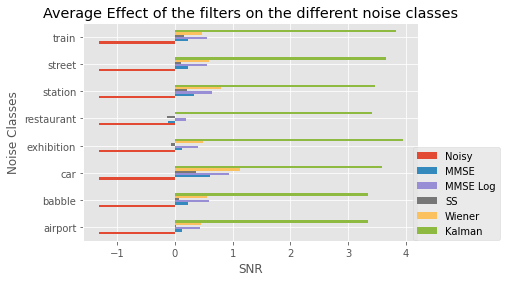

In [141]:
fig, ax = plt.subplots()
data.plot.barh(ax=ax, legend=False)
ax.yaxis.set_label_text('Noise Classes')
ax.set_title('Average Effect of the filters on the different noise classes')
ax.xaxis.set_label_text('SNR')
fig.legend(bbox_to_anchor=(1.1, 0.469))
fig.savefig('../docs/plots/Filter_effects_avg.png')
plt.show()

## Plot of Average SNR values of the different noise classes at 0dB


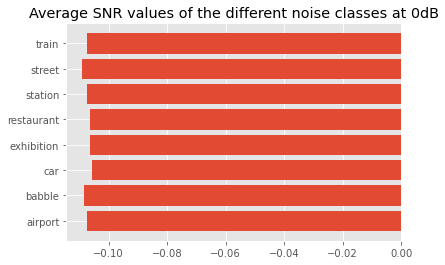

In [155]:
snr_classes_0dB = []

for noise_class in noise_classes:
    for i in range(30):
        val = 0
        if (i<9):
            val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_0dB/sp0"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
        if (i>=10):
            val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_0dB/sp"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
    
    snr_classes_0dB.append(val/30)

plt.barh(noise_classes, snr_classes_0dB)
plt.title('Average SNR values of the different noise classes at 0dB')
plt.savefig('../docs/plots/avg_snr_raw_0db.png')

## Plot of Average SNR values of different noise classes at 5dB


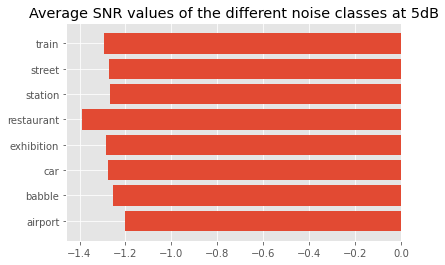

In [156]:
snr_classes_5dB = []

for noise_class in noise_classes:
    for i in range(30):
        val = 0
        if (i<9):
            val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_5dB/sp0"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
        if (i>=10):
            val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_5dB/sp"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
    
    snr_classes_5dB.append(val/30)

plt.barh(noise_classes, snr_classes_5db)
plt.title('Average SNR values of the different noise classes at 5dB')
plt.savefig('../docs/plots/avg_snr_raw_5db.png')

## Plot of Average SNR values of different noise classes at 10dB


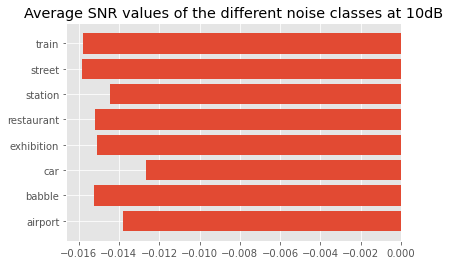

In [157]:
snr_classes_10dB = []

for noise_class in noise_classes:
    for i in range(30):
        val = 0
        if (i<9):
            val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_10dB/sp0"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
        if (i>=10):
            val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_10dB/sp"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
    
    snr_classes_10dB.append(val/30)

plt.barh(noise_classes, snr_classes_10dB)
plt.title('Average SNR values of the different noise classes at 10dB')
plt.savefig('../docs/plots/avg_snr_raw_10db.png')

## Plot of Average SNR values of different noise classes at 15dB


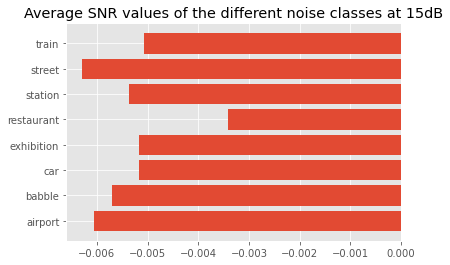

In [158]:
snr_classes_15dB = []

for noise_class in noise_classes:
    for i in range(30):
        val = 0
        if (i<9):
            val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_15dB/sp0"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
        if (i>=10):
            val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/noisy/"+str(noise_class)+"_15dB/sp"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
    
    snr_classes_15dB.append(val/30)

plt.barh(noise_classes, snr_classes_15dB)
plt.title('Average SNR values of the different noise classes at 15dB')
plt.savefig('../docs/plots/avg_snr_raw_15db.png')

# Now let's apply our filters!


## Effect of applying filters on different noise classes at 0db


In [146]:
mmse_0db = []
mmse_log_0db = []
ss_0db = []
wiener_0db = []
kalman_0db = []

for noise_class in noise_classes:
    for i in range(30):
        mmse_val = 0    
        mmse_log_val = 0
        ss_val = 0
        wiener_val = 0
        kalman_val = 0
        if (i<9):
            mmse_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_0dB/mmse_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_0dB/mmse_log_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            wiener_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_0dB/wiener_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            ss_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_0dB/ss_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            kalman_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_0dB/kalman_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
        if (i>=10):
            mmse_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_0dB/mmse_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_0dB/mmse_log_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            wiener_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_0dB/wiener_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            ss_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_0dB/ss_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
            kalman_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_0dB/kalman_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn0.wav")
    
    mmse_0db.append(mmse_val/30)
    mmse_log_0db.append(mmse_val/30)
    ss_0db.append(ss_val/30)
    wiener_0db.append(wiener_val/30)
    kalman_0db.append(kalman_val/30)


data = pd.DataFrame({'Noisy': snr_classes_0dB,'MMSE': mmse_0db, 'MMSE Log': mmse_log_0db, 'SS': ss_0db, 'Wiener': wiener_0db, 'Kalman': kalman_0db}, index = noise_classes)

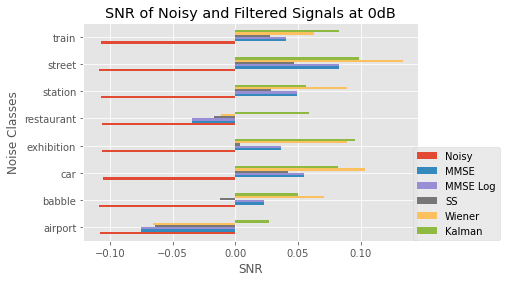

In [147]:
fig, ax = plt.subplots()
data.plot.barh(ax=ax, legend=False)
ax.yaxis.set_label_text('Noise Classes')
ax.set_title('SNR of Noisy and Filtered Signals at 0dB')
ax.xaxis.set_label_text('SNR')
fig.legend(bbox_to_anchor=(1.1, 0.469))
fig.savefig('../docs/plots/Filter_effects_0dB.png')
plt.show()

## Effect of applying filters on different noise classes at 5db

In [148]:
mmse_5db = []
mmse_log_5db = []
ss_5db = []
wiener_5db = []
kalman_5db = []

for noise_class in noise_classes:
    for i in range(30):
        mmse_val = 0    
        mmse_log_val = 0
        ss_val = 0
        wiener_val = 0
        kalman_val = 0
        if (i<9):
            mmse_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_5dB/mmse_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_5dB/mmse_log_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            wiener_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_5dB/wiener_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            ss_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_5dB/ss_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            kalman_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_5dB/kalman_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
        if (i>=10):
            mmse_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_5dB/mmse_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_5dB/mmse_log_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            wiener_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_5dB/wiener_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            ss_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_5dB/ss_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
            kalman_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_5dB/kalman_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn5.wav")
    
    mmse_5db.append(mmse_val/30)
    mmse_log_5db.append(mmse_val/30)
    ss_5db.append(ss_val/30)
    wiener_5db.append(wiener_val/30)
    kalman_5db.append(kalman_val/30)


data = pd.DataFrame({'Noisy': snr_classes_5dB,'MMSE': mmse_5db, 'MMSE Log': mmse_log_5db, 'SS': ss_5db, 'Wiener': wiener_5db, 'Kalman': kalman_5db}, index = noise_classes)

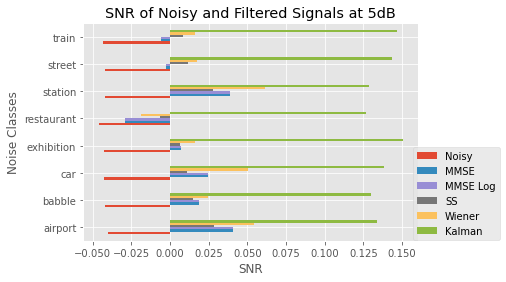

In [149]:
fig, ax = plt.subplots()
data.plot.barh(ax=ax, legend=False)
ax.yaxis.set_label_text('Noise Classes')
ax.set_title('SNR of Noisy and Filtered Signals at 5dB')
ax.xaxis.set_label_text('SNR')
fig.legend(bbox_to_anchor=(1.1, 0.469))
fig.savefig('../docs/plots/Filter_effects_5dB.png')
plt.show()

## Effect of applying filters on different noise classes at 10dB

In [150]:
mmse_10db = []
mmse_log_10db = []
ss_10db = []
wiener_10db = []
kalman_10db = []

for noise_class in noise_classes:
    for i in range(30):
        mmse_val = 0    
        mmse_log_val = 0
        ss_val = 0
        wiener_val = 0
        if (i<9):
            mmse_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_10dB/mmse_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_10dB/mmse_log_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            wiener_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_10dB/wiener_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            ss_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_10dB/ss_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            kalman_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_10dB/kalman_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
        if (i>=10):
            mmse_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_10dB/mmse_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_10dB/mmse_log_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            wiener_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_10dB/wiener_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            ss_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_10dB/ss_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
            kalman_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_10dB/kalman_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn10.wav")
    
    mmse_10db.append(mmse_val/30)
    mmse_log_10db.append(mmse_val/30)
    ss_10db.append(ss_val/30)
    wiener_10db.append(wiener_val/30)
    kalman_10db.append(kalman_val/30)


data = pd.DataFrame({'Noisy': snr_classes_10dB,'MMSE': mmse_10db, 'MMSE Log': mmse_log_10db, 'SS': ss_10db, 'Wiener': wiener_10db, 'Kalman': kalman_10db}, index = noise_classes)

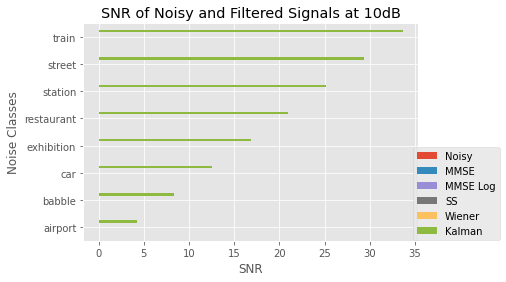

In [151]:
fig, ax = plt.subplots()
data.plot.barh(ax=ax, legend=False)
ax.yaxis.set_label_text('Noise Classes')
ax.set_title('SNR of Noisy and Filtered Signals at 10dB')
ax.xaxis.set_label_text('SNR')
fig.legend(bbox_to_anchor=(1.1, 0.469))
fig.savefig('../docs/plots/Filter_effects_10dB.png')
plt.show()

## Effect of applying filters on different noise classes at 15dB

In [152]:
mmse_15db = []
mmse_log_15db = []
ss_15db = []
wiener_15db = []
kalman_15db = []

for noise_class in noise_classes:
    for i in range(30):
        mmse_val = 0    
        mmse_log_val = 0
        ss_val = 0
        wiener_val = 0
        kalman_val = 0
        if (i<9):
            mmse_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_15dB/mmse_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_15dB/mmse_log_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            wiener_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_15dB/wiener_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            ss_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_15dB/ss_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            kalman_val += snr_abs("../Dataset/clean/sp0"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_15dB/kalman_filtered_sp0"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
        if (i>=10):
            mmse_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE/"+str(noise_class)+"_15dB/mmse_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            mmse_log_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/MMSE_Log/"+str(noise_class)+"_15dB/mmse_log_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            wiener_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Wiener/"+str(noise_class)+"_15dB/wiener_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            ss_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Spectral_Subtraction/"+str(noise_class)+"_15dB/ss_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
            kalman_val += snr_abs("../Dataset/clean/sp"+str(i+1)+".wav", "../Dataset/Filtered/Kalman/"+str(noise_class)+"_15dB/kalman_filtered_sp"+str(i+1)+"_"+str(noise_class)+"_sn15.wav")
    
    mmse_15db.append(mmse_val/30)
    mmse_log_15db.append(mmse_val/30)
    ss_15db.append(ss_val/30)
    wiener_15db.append(wiener_val/30)
    kalman_15db.append(kalman_val/30)

data = pd.DataFrame({'Noisy': snr_classes_15dB,'MMSE': mmse_15db, 'MMSE Log': mmse_log_15db, 'SS': ss_15db, 'Wiener': wiener_15db, 'Kalman': kalman_15db}, index = noise_classes)

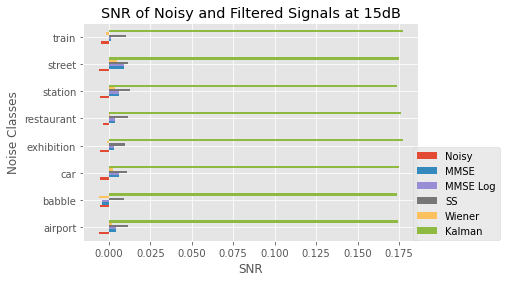

In [153]:
fig, ax = plt.subplots()
data.plot.barh(ax=ax, legend=False)
ax.yaxis.set_label_text('Noise Classes')
ax.set_title('SNR of Noisy and Filtered Signals at 15dB')
ax.xaxis.set_label_text('SNR')
fig.legend(bbox_to_anchor=(1.1, 0.469))
fig.savefig('../docs/plots/Filter_effects_15dB.png')
plt.show()